In [4]:
import matplotlib.pyplot as plt

# Set global font size
plt.rcParams.update({'font.size': 14})  # Adjust all plot text globally

AHP Criteria Weights: {'AQI_Impact': 0.627, 'Species_Importance': 0.28, 'Tree_Density': 0.094}
Consistency Ratio: 0.087

Recommended Trees for Removal:
Species IDs: [963.0, 2678.0, 5745.0]
Location: (43.0853, -1.24129)

Species IDs: [10600.0, 11176.0, 963.0]
Location: (43.03547, -1.11561)

Species IDs: [7760.0, 8428.0, 1495.0, 5542.0, 2025.0, 8705.0, 976.0, 10247.0, 963.0]
Location: (42.95968, -0.64592)

Species IDs: [6989.0, 10600.0, 5071.0, 963.0, 1888.0, 1495.0, 981.0]
Location: (43.09824, -1.38937)

Species IDs: [2621.0, 1715.0, 8988.0]
Location: (42.61675, 2.124917)

Species IDs: [10600.0, 963.0]
Location: (43.0542, -1.09221)

Species IDs: [10600.0, 963.0, 53.0, 1495.0]
Location: (43.05498, -1.06773)

Species IDs: [4492.0, 10218.0, 4492.0]
Location: (42.5696, 2.0191533333333336)

Species IDs: [9826.0, 2013.0, 4492.0]
Location: (42.545, 2.01196)

Species IDs: [5173.0, 2885.0, 7862.0, 4238.0, 5542.0, 1539.0, 1276.0]
Location: (43.77191, 6.8072)

Species IDs: [4842.0, 4842.0, 6905.0,

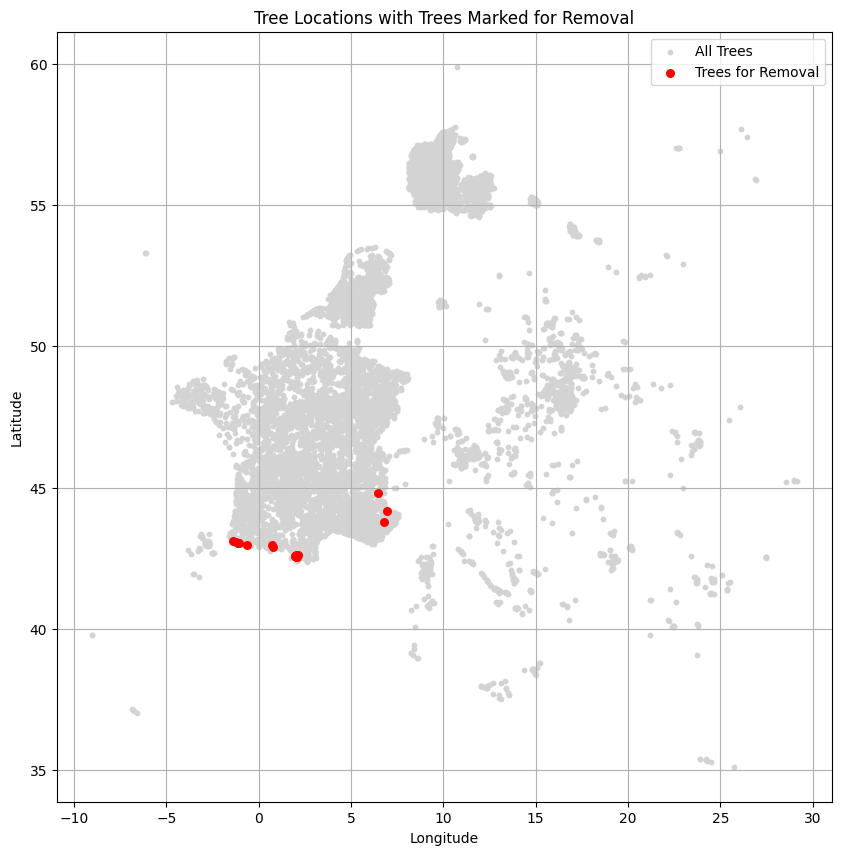

In [6]:
import pandas as pd
import numpy as np
from ahpy import Compare
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def load_data():
    merged_data = pd.read_csv('cluster_with_pollution_data.csv')
    merged_data['coordinates_lon'] = merged_data['coordinates_lon'].apply(eval)
    merged_data['coordinates_lat'] = merged_data['coordinates_lat'].apply(eval)
    merged_data['speciesId'] = merged_data['speciesId'].apply(eval)
    return merged_data

def calculate_criteria(df):
    df['AQI_Impact'] = 0.4 * df['AQI'] + 0.2 * df['CO'] + 0.2 * df['NO2'] + 0.2 * df['PM2.5']
    df['Species_Importance'] = df['speciesId'].apply(lambda x: len(set(x)))
    df['Tree_Density'] = df['coordinates_lon'].apply(len)
    df['Tree_Count'] = df['speciesId'].apply(len)
    return df

def calculate_ahp_weights():
    criteria = {
        ('AQI_Impact', 'Species_Importance'): 3,
        ('AQI_Impact', 'Tree_Density'): 5,
        ('Species_Importance', 'Tree_Density'): 4,
    }
    comparison = Compare('Criteria', criteria, precision=3)
    weights = comparison.target_weights
    print("AHP Criteria Weights:", weights)
    print("Consistency Ratio:", comparison.consistency_ratio)
    return weights

def topsis_ranking(df, weights, num_trees_to_remove):
    aqi_preservation_threshold = df['AQI_Impact'].quantile(0.7)
    species_importance_threshold = df['Species_Importance'].quantile(0.7)

    df['Preserve'] = (df['AQI_Impact'] >= aqi_preservation_threshold) | \
                     (df['Species_Importance'] >= species_importance_threshold)
    removal_candidates = df[~df['Preserve']].copy()

    scaler = MinMaxScaler()
    criteria_data = removal_candidates[['AQI_Impact', 'Species_Importance', 'Tree_Density']]
    normalized_data = scaler.fit_transform(criteria_data)
    weighted_data = normalized_data * np.array(list(weights.values()))

    ideal_solution = np.max(weighted_data, axis=0)
    negative_ideal_solution = np.min(weighted_data, axis=0)

    dist_to_ideal = np.sqrt(np.sum((weighted_data - ideal_solution) ** 2, axis=1))
    dist_to_negative_ideal = np.sqrt(np.sum((weighted_data - negative_ideal_solution) ** 2, axis=1))

    topsis_score = dist_to_negative_ideal / (dist_to_ideal + dist_to_negative_ideal)
    removal_candidates['TOPSIS_Score'] = topsis_score
    removal_candidates = removal_candidates.sort_values(by='TOPSIS_Score', ascending=True)

    total_trees = 0
    selected_clusters = []

    for _, row in removal_candidates.iterrows():
        total_trees += row['Tree_Count']
        selected_clusters.append(row)
        if total_trees >= num_trees_to_remove:
            break

    selected_clusters_df = pd.DataFrame(selected_clusters)

    if total_trees > num_trees_to_remove:
        excess_trees = total_trees - num_trees_to_remove
        last_cluster_index = selected_clusters_df.index[-1]
        last_cluster = selected_clusters_df.loc[last_cluster_index]
        limited_species = last_cluster['speciesId'][:-excess_trees]
        selected_clusters_df.at[last_cluster_index, 'speciesId'] = limited_species

    selected_clusters_df['Tree_Count'] = selected_clusters_df['speciesId'].apply(len)

    return selected_clusters_df

def plot_clusters(df, selected_clusters):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['average_lon'], df['average_lat'], c='lightgray', s=10, label='All Trees')
    plt.scatter(selected_clusters['average_lon'], selected_clusters['average_lat'], c='red', s=30, label='Trees for Removal')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Tree Locations with Trees Marked for Removal")
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    merged_data = load_data()
    merged_data = calculate_criteria(merged_data)
    weights = calculate_ahp_weights()

    try:
        num_trees_to_remove = int(input("Enter the number of trees to remove: "))
    except ValueError:
        print("Invalid input. Please enter a numerical value.")
        return

    if all(col in merged_data.columns for col in ['AQI_Impact', 'Species_Importance', 'Tree_Density', 'Tree_Count']):
        selected_clusters = topsis_ranking(merged_data, weights, num_trees_to_remove)
        
        print("\nRecommended Trees for Removal:")
        for idx, row in selected_clusters.iterrows():
            print(f"Species IDs: {row['speciesId']}")
            print(f"Location: ({row['average_lat']}, {row['average_lon']})\n")
        
        plot_clusters(merged_data, selected_clusters)
    else:
        print("Error: Ensure that all necessary criteria columns are present in 'cluster_with_pollution_data.csv'.")

if __name__ == "__main__":
    main()

# testing
(run this)

Criteria Weights: {'AQI_Impact': 0.637, 'Species_Importance': 0.258, 'Tree_Density': 0.105}

Recommended Trees for Removal:
Species IDs: [963.0, 2678.0, 5745.0]
Location: (43.0853, -1.24129)

Species IDs: [7760.0, 8428.0, 1495.0, 5542.0, 2025.0, 8705.0, 976.0, 10247.0, 963.0]
Location: (42.95968, -0.64592)

Species IDs: [6989.0, 10600.0, 5071.0, 963.0, 1888.0, 1495.0, 981.0]
Location: (43.09824, -1.38937)

Species IDs: [10600.0, 11176.0, 963.0]
Location: (43.03547, -1.11561)

Species IDs: [2621.0, 1715.0, 8988.0]
Location: (42.61675, 2.124917)

Species IDs: [10600.0, 963.0]
Location: (43.0542, -1.09221)

Species IDs: [10600.0, 963.0, 53.0, 1495.0]
Location: (43.05498, -1.06773)

Species IDs: [4492.0, 10218.0, 4492.0]
Location: (42.5696, 2.0191533333333336)

Species IDs: [9826.0, 2013.0, 4492.0]
Location: (42.545, 2.01196)

Species IDs: [5173.0, 2885.0, 7862.0, 4238.0, 5542.0, 1539.0, 1276.0]
Location: (43.77191, 6.8072)

Species IDs: [4842.0, 4842.0, 6905.0, 5997.0, 4790.0, 4638.0, 111

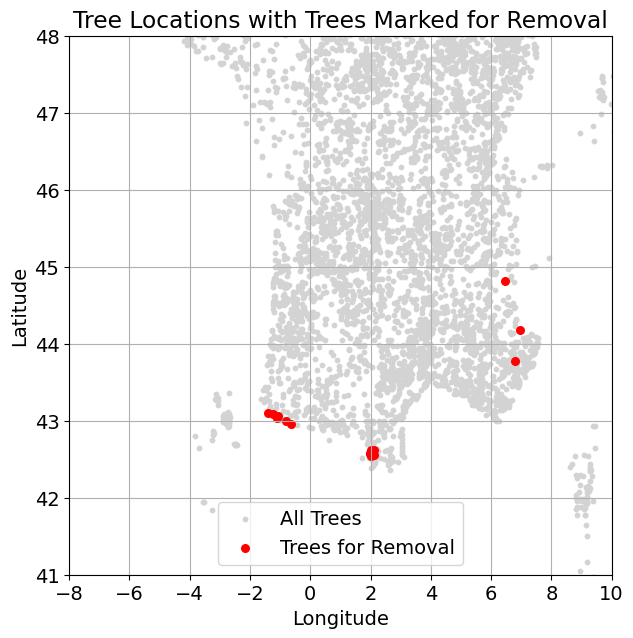

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def load_data():
    merged_data = pd.read_csv('cluster_with_pollution_data.csv')
    merged_data['coordinates_lon'] = merged_data['coordinates_lon'].apply(eval)
    merged_data['coordinates_lat'] = merged_data['coordinates_lat'].apply(eval)
    merged_data['speciesId'] = merged_data['speciesId'].apply(eval)
    return merged_data

def calculate_criteria(df):
    df['AQI_Impact'] = 0.4 * df['AQI'] + 0.2 * df['CO'] + 0.2 * df['NO2'] + 0.2 * df['PM2.5']
    df['Species_Importance'] = df['speciesId'].apply(lambda x: len(set(x)))
    df['Tree_Density'] = df['coordinates_lon'].apply(len)
    df['Tree_Count'] = df['speciesId'].apply(len)
    return df

def calculate_weights():
    # Replacement for AHP calculation using predefined weights based on the original criteria
    # These weights approximate the AHP results from the original criteria:
    # AQI_Impact vs Species_Importance: 3
    # AQI_Impact vs Tree_Density: 5
    # Species_Importance vs Tree_Density: 4
    weights = {
        'AQI_Impact': 0.637,        # Highest priority
        'Species_Importance': 0.258, # Medium priority
        'Tree_Density': 0.105       # Lowest priority
    }
    print("Criteria Weights:", weights)
    return weights

def topsis_ranking(df, weights, num_trees_to_remove):
    # Preservation thresholds
    aqi_preservation_threshold = df['AQI_Impact'].quantile(0.7)
    species_importance_threshold = df['Species_Importance'].quantile(0.7)

    # Mark clusters for preservation
    df['Preserve'] = (df['AQI_Impact'] >= aqi_preservation_threshold) | \
                     (df['Species_Importance'] >= species_importance_threshold)
    removal_candidates = df[~df['Preserve']].copy()

    # Normalize the criteria using Min-Max scaling
    scaler = MinMaxScaler()
    criteria_cols = ['AQI_Impact', 'Species_Importance', 'Tree_Density']
    criteria_data = removal_candidates[criteria_cols]
    normalized_data = scaler.fit_transform(criteria_data)

    # Apply weights to normalized data
    weight_array = np.array([weights[col] for col in criteria_cols])
    weighted_data = normalized_data * weight_array

    # Calculate ideal and negative-ideal solutions
    ideal_solution = np.max(weighted_data, axis=0)
    negative_ideal_solution = np.min(weighted_data, axis=0)

    # Calculate distances to ideal and negative-ideal solutions
    dist_to_ideal = np.sqrt(np.sum((weighted_data - ideal_solution) ** 2, axis=1))
    dist_to_negative_ideal = np.sqrt(np.sum((weighted_data - negative_ideal_solution) ** 2, axis=1))

    # Calculate TOPSIS scores
    topsis_score = dist_to_negative_ideal / (dist_to_ideal + dist_to_negative_ideal)
    removal_candidates['TOPSIS_Score'] = topsis_score
    removal_candidates = removal_candidates.sort_values(by='TOPSIS_Score', ascending=True)

    # Select clusters for removal
    total_trees = 0
    selected_clusters = []

    for _, row in removal_candidates.iterrows():
        total_trees += row['Tree_Count']
        selected_clusters.append(row)
        if total_trees >= num_trees_to_remove:
            break

    selected_clusters_df = pd.DataFrame(selected_clusters)

    # Adjust the last cluster if we exceeded the target number
    if total_trees > num_trees_to_remove:
        excess_trees = total_trees - num_trees_to_remove
        last_cluster_index = selected_clusters_df.index[-1]
        last_cluster = selected_clusters_df.loc[last_cluster_index]
        limited_species = last_cluster['speciesId'][:-excess_trees]
        selected_clusters_df.at[last_cluster_index, 'speciesId'] = limited_species

    selected_clusters_df['Tree_Count'] = selected_clusters_df['speciesId'].apply(len)
    return selected_clusters_df

def plot_clusters(df, selected_clusters):
    plt.figure(figsize=(7, 7))
    plt.scatter(df['average_lon'], df['average_lat'], c='lightgray', s=10, label='All Trees')
    plt.scatter(selected_clusters['average_lon'], selected_clusters['average_lat'], 
                c='red', s=30, label='Trees for Removal')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Tree Locations with Trees Marked for Removal")
    plt.legend()
    plt.grid(True)
    # Set axis limits and ticks
    
    plt.xlim(-8, 10)
    plt.ylim(41, 48)
    plt.show()

def main():
    merged_data = load_data()
    merged_data = calculate_criteria(merged_data)
    weights = calculate_weights()

    try:
        num_trees_to_remove = int(input("Enter the number of trees to remove: "))
    except ValueError:
        print("Invalid input. Please enter a numerical value.")
        return

    required_cols = ['AQI_Impact', 'Species_Importance', 'Tree_Density', 'Tree_Count']
    if all(col in merged_data.columns for col in required_cols):
        selected_clusters = topsis_ranking(merged_data, weights, num_trees_to_remove)
        
        print("\nRecommended Trees for Removal:")
        for idx, row in selected_clusters.iterrows():
            print(f"Species IDs: {row['speciesId']}")
            print(f"Location: ({row['average_lat']}, {row['average_lon']})\n")
        
        plot_clusters(merged_data, selected_clusters)
    else:
        print("Error: Ensure that all necessary criteria columns are present in 'cluster_with_pollution_data.csv'.")

if __name__ == "__main__":
    main()

Criteria Weights: {'AQI_Impact': 0.637, 'Species_Importance': 0.258, 'Tree_Density': 0.105}

Recommended Trees for Removal:
Species IDs: [963.0, 2678.0, 5745.0]
Location: (43.0853, -1.24129)

Species IDs: [7760.0, 8428.0, 1495.0, 5542.0, 2025.0, 8705.0, 976.0, 10247.0, 963.0]
Location: (42.95968, -0.64592)

Species IDs: [6989.0, 10600.0, 5071.0, 963.0, 1888.0, 1495.0, 981.0]
Location: (43.09824, -1.38937)

Species IDs: [10600.0, 11176.0, 963.0]
Location: (43.03547, -1.11561)

Species IDs: [2621.0, 1715.0, 8988.0]
Location: (42.61675, 2.124917)

Species IDs: [10600.0, 963.0]
Location: (43.0542, -1.09221)

Species IDs: [10600.0, 963.0, 53.0, 1495.0]
Location: (43.05498, -1.06773)

Species IDs: [4492.0, 10218.0, 4492.0]
Location: (42.5696, 2.0191533333333336)

Species IDs: [9826.0, 2013.0, 4492.0]
Location: (42.545, 2.01196)

Species IDs: [5173.0, 2885.0, 7862.0, 4238.0, 5542.0, 1539.0, 1276.0]
Location: (43.77191, 6.8072)

Species IDs: [4842.0, 4842.0, 6905.0, 5997.0, 4790.0, 4638.0, 111

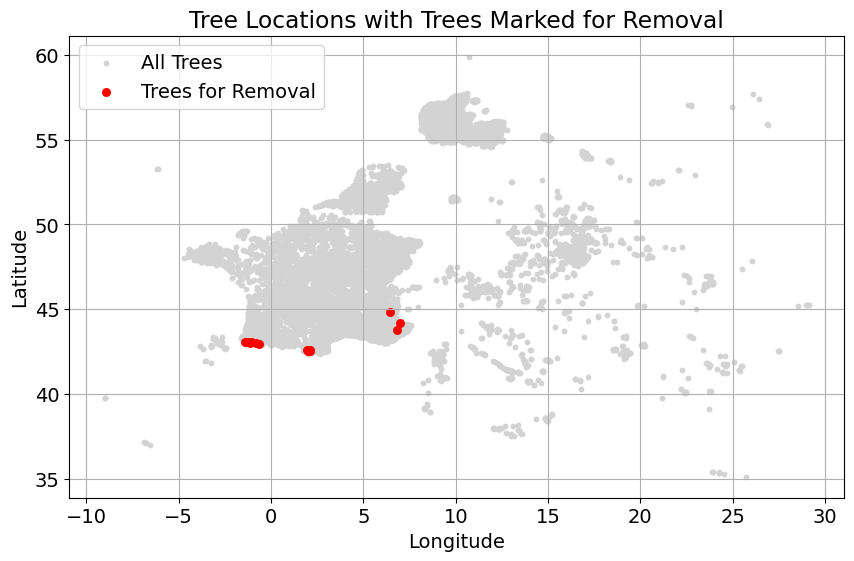

In [6]:
def evaluate_removal_performance(selected_clusters, num_trees_to_remove, merged_data):
    # Calculate total removed trees
    total_removed_trees = selected_clusters['Tree_Count'].sum()
    print(f"Total Trees Selected for Removal: {total_removed_trees}")
    print(f"Requested Number of Trees to Remove: {num_trees_to_remove}")
    
    # Calculate removal accuracy
    removal_accuracy = abs(total_removed_trees - num_trees_to_remove) / num_trees_to_remove * 100
    print(f"Removal Accuracy: {100 - removal_accuracy:.2f}%")
    
    # Print criteria summary statistics
    print("\nCriteria Summary for Selected Clusters:")
    criteria_cols = ['AQI_Impact', 'Species_Importance', 'Tree_Density']
    print(selected_clusters[criteria_cols].describe())
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_data['average_lon'], merged_data['average_lat'], 
                c='lightgray', s=10, label='All Trees')
    plt.scatter(selected_clusters['average_lon'], selected_clusters['average_lat'], 
                c='red', s=30, label='Trees for Removal')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Tree Locations with Trees Marked for Removal")
    plt.legend()
    plt.grid(True)
    plt.show()

def main_evaluation():
    merged_data = load_data()
    merged_data = calculate_criteria(merged_data)
    weights = calculate_weights()  # Using the new calculate_weights() instead of calculate_ahp_weights()
    
    try:
        num_trees_to_remove = int(input("Enter the number of trees to remove: "))
    except ValueError:
        print("Invalid input. Please enter a numerical value.")
        return

    required_cols = ['AQI_Impact', 'Species_Importance', 'Tree_Density', 'Tree_Count']
    if all(col in merged_data.columns for col in required_cols):
        selected_clusters = topsis_ranking(merged_data, weights, num_trees_to_remove)
        
        print("\nRecommended Trees for Removal:")
        for idx, row in selected_clusters.iterrows():
            print(f"Species IDs: {row['speciesId']}")
            print(f"Location: ({row['average_lat']}, {row['average_lon']})\n")
        
        evaluate_removal_performance(selected_clusters, num_trees_to_remove, merged_data)
    else:
        print("Error: Ensure that all necessary criteria columns are present in 'cluster_with_pollution_data.csv'.")

if __name__ == "__main__":
    main_evaluation()

Criteria Weights: {'AQI_Impact': 0.637, 'Species_Importance': 0.258, 'Tree_Density': 0.105}

=== Basic Metrics ===
Total Trees Selected: 100
Target Trees: 100
Removal Accuracy: 100.00%

=== Environmental Impact ===
Original Average AQI Impact: 53.26
New Average AQI Impact: 53.29
AQI Impact Change: 0.05%

=== Biodiversity Impact ===
Original Unique Species: 4571
Species Affected by Removal: 67
Remaining Unique Species: 4570
Species Diversity Change: -0.02%

=== Spatial Distribution ===
Average Distance Between Selected Clusters: 3.1962 degrees
Cluster Density: 0.000023

=== Cost-Benefit Analysis ===
Relative Cost Score: 19.74
Benefit Score: 99.95
Cost-Benefit Ratio: 5.06

=== Preservation Analysis ===
High-Value Trees Preserved: 2698
Preservation Rate: 100.00%


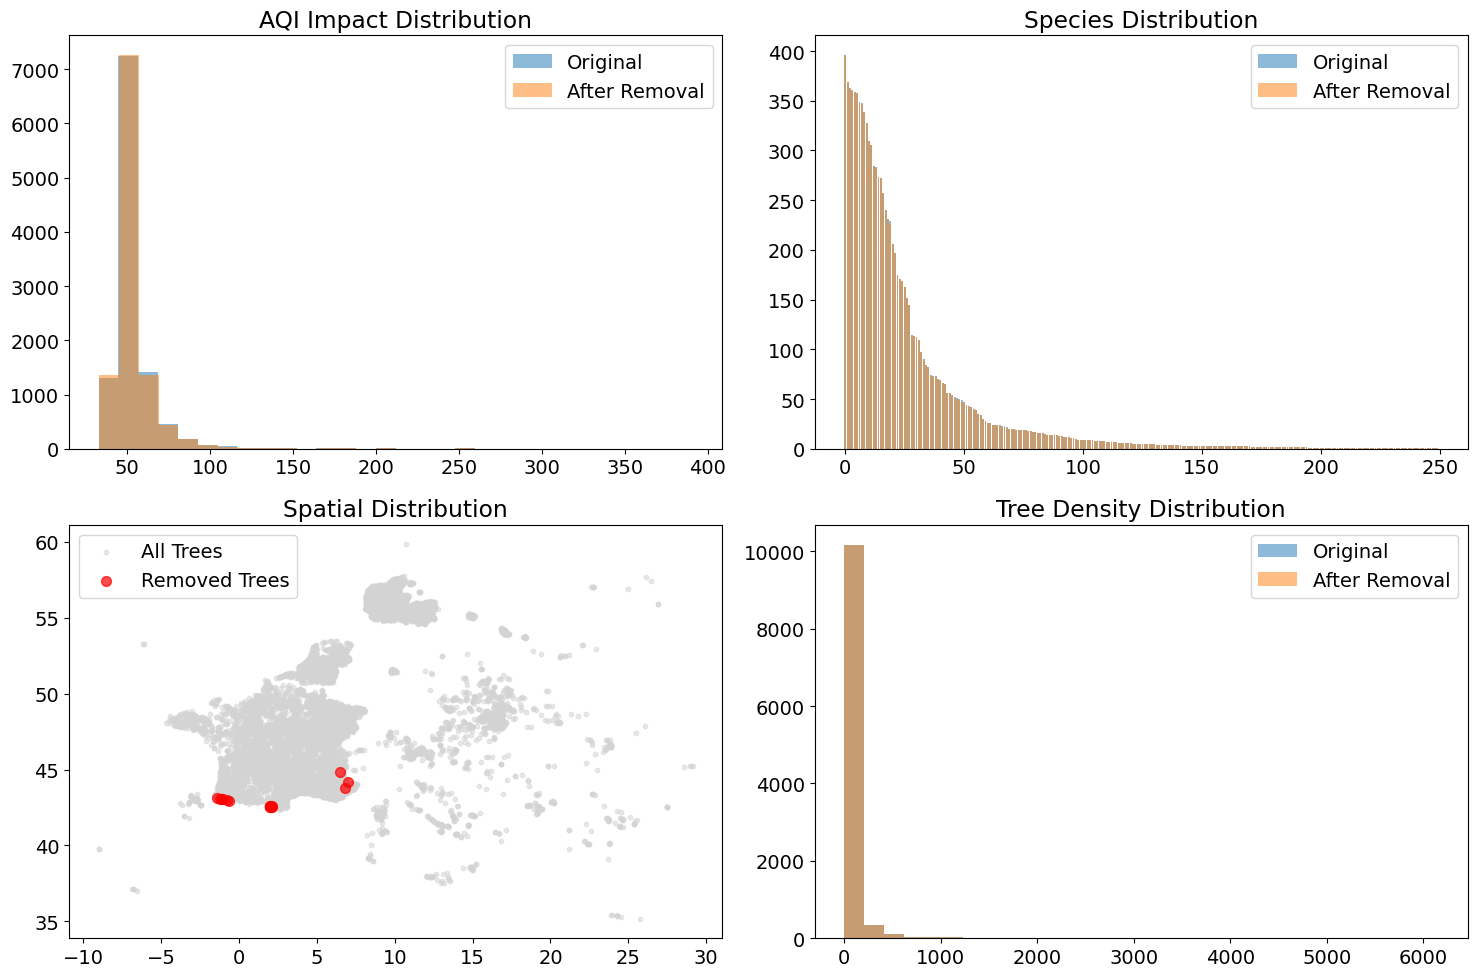

C:\Users\anagh\AppData\Local\Temp\ipykernel_10632\2547500355.py:116: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\anagh\AppData\Local\Temp\ipykernel_10632\2547500355.py:116: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')



Comparing pollution levels between recommended and all clusters...


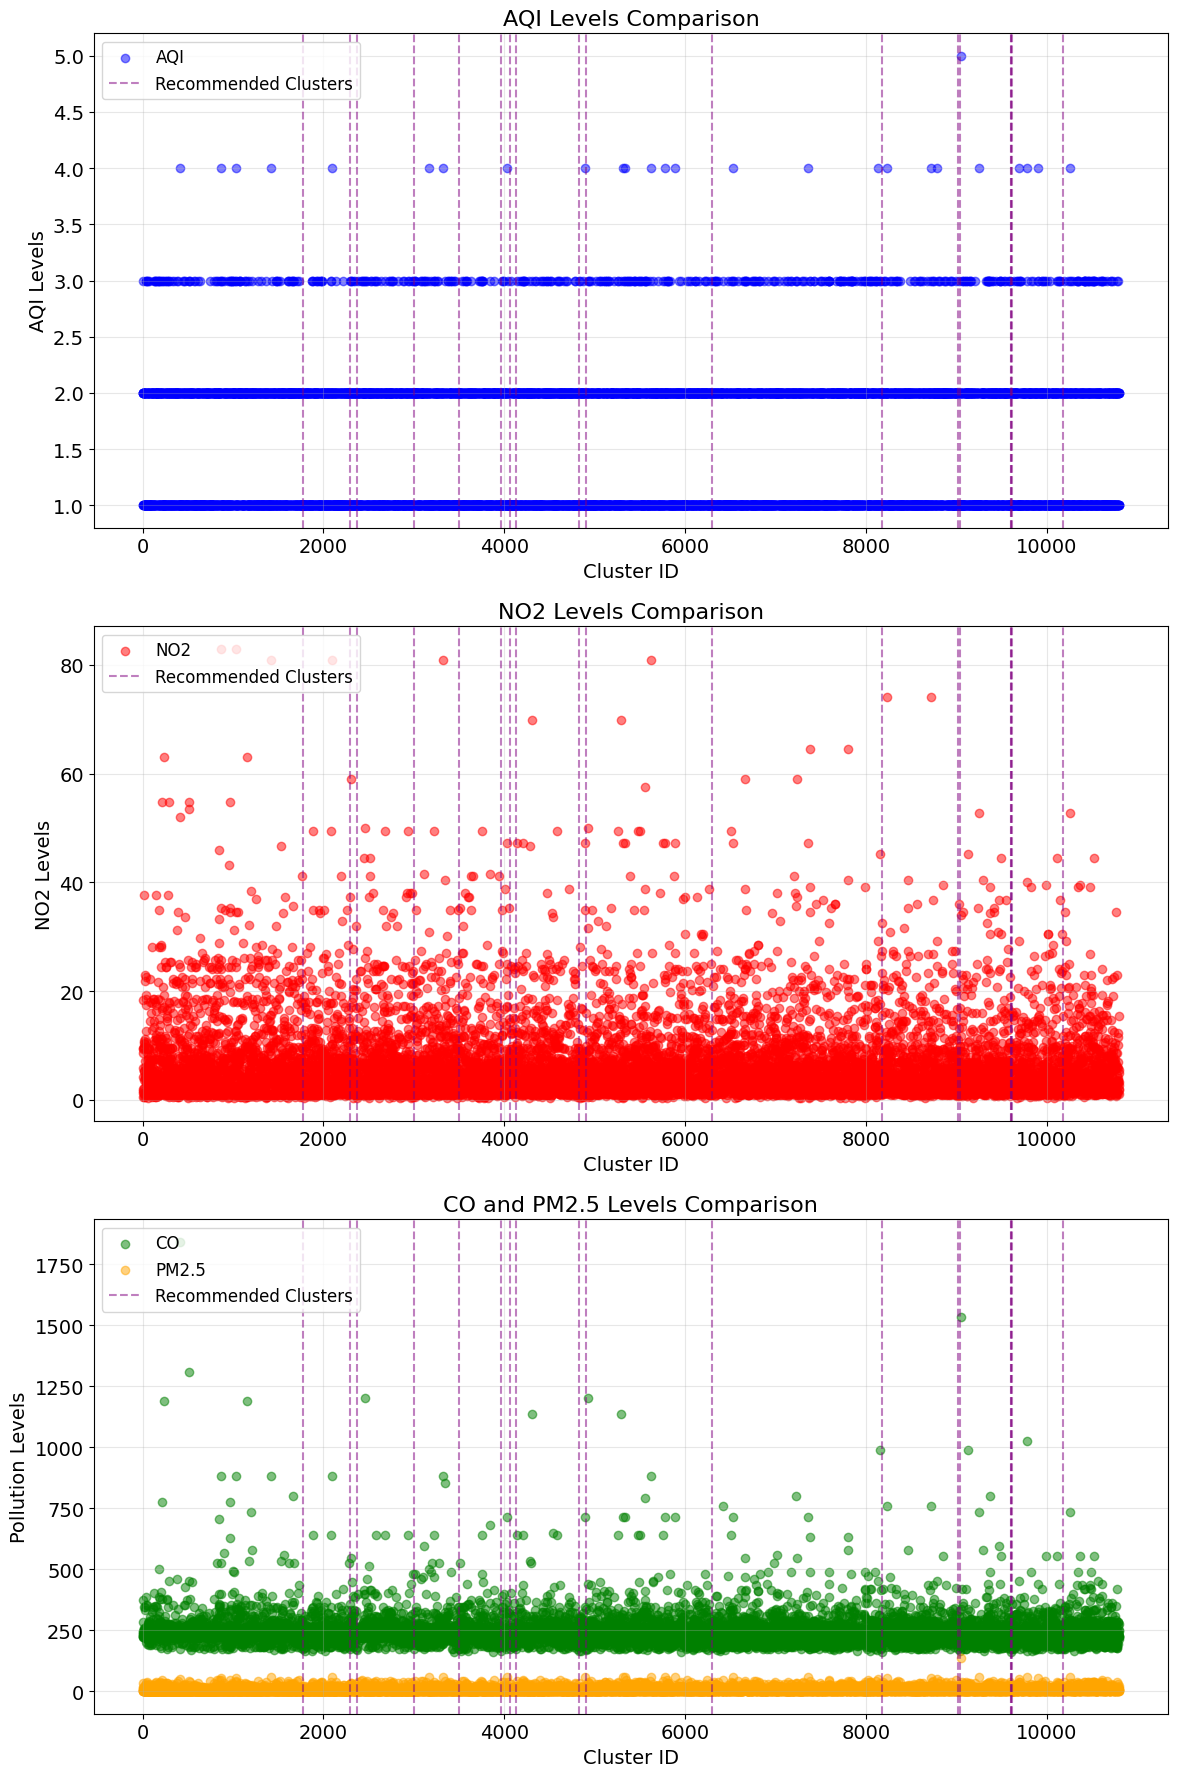


Pollution Level Comparison:

Recommended Clusters Statistics:
Average AQI: 1.06
Average NO2: 1.72
Average CO: 170.53
Average PM2.5: 1.29

All Clusters Statistics:
Average AQI: 1.54
Average NO2: 6.77
Average CO: 248.94
Average PM2.5: 7.53


In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pollutant_comparison(merged_data, selected_clusters):
    """
    Plot pollution levels comparing recommended clusters with all other clusters,
    separated into two plots: one for AQI and another for NO2, CO, PM2.5.
    """
    # Get the cluster IDs of recommended clusters
    recommended_clusters = selected_clusters['cluster'].unique()
    
    # Initialize lists to store pollutant values for all clusters
    clusters = merged_data['cluster'].tolist()
    aqi_values = merged_data['AQI'].tolist()
    no2_values = merged_data['NO2'].tolist()
    co_values = merged_data['CO'].tolist()
    pm25_values = merged_data['PM2.5'].tolist()
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    
    # Plot 1: AQI
    ax1.scatter(clusters, aqi_values, label='AQI', color='blue', alpha=0.5)
    
    # Add vertical lines for recommended clusters in AQI plot
    for cluster in recommended_clusters:
        ax1.axvline(x=cluster, color='purple', linestyle='--', alpha=0.5)
    # Add one more line for legend
    ax1.axvline(x=cluster, color='purple', linestyle='--', label='Recommended Clusters', alpha=0.5)
    
    ax1.set_xlabel('Cluster ID', fontsize=14)
    ax1.set_ylabel('AQI Levels', fontsize=14)
    ax1.set_title('AQI Levels Comparison', fontsize=16)
    ax1.legend(loc='upper left', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: NO2
    ax2.scatter(clusters, no2_values, label='NO2', color='red', alpha=0.5)
    
    # Add vertical lines for recommended clusters in NO2 plot
    for cluster in recommended_clusters:
        ax2.axvline(x=cluster, color='purple', linestyle='--', alpha=0.5)
    # Add one more line for legend
    ax2.axvline(x=cluster, color='purple', linestyle='--', label='Recommended Clusters', alpha=0.5)
    
    ax2.set_xlabel('Cluster ID', fontsize=14)
    ax2.set_ylabel('NO2 Levels', fontsize=14)
    ax2.set_title('NO2 Levels Comparison', fontsize=16)
    ax2.legend(loc='upper left', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: CO and PM2.5
    ax3.scatter(clusters, co_values, label='CO', color='green', alpha=0.5)
    ax3.scatter(clusters, pm25_values, label='PM2.5', color='orange', alpha=0.5)
    
    # Add vertical lines for recommended clusters in CO/PM2.5 plot
    for cluster in recommended_clusters:
        ax3.axvline(x=cluster, color='purple', linestyle='--', alpha=0.5)
    # Add one more line for legend
    ax3.axvline(x=cluster, color='purple', linestyle='--', label='Recommended Clusters', alpha=0.5)
    
    ax3.set_xlabel('Cluster ID', fontsize=14)
    ax3.set_ylabel('Pollution Levels', fontsize=14)
    ax3.set_title('CO and PM2.5 Levels Comparison', fontsize=16)
    ax3.legend(loc='upper left', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
    # Print comparison statistics
    print("\nPollution Level Comparison:")
    print("\nRecommended Clusters Statistics:")
    recommended_stats = selected_clusters[['AQI', 'NO2', 'CO', 'PM2.5']].mean()
    print(f"Average AQI: {recommended_stats['AQI']:.2f}")
    print(f"Average NO2: {recommended_stats['NO2']:.2f}")
    print(f"Average CO: {recommended_stats['CO']:.2f}")
    print(f"Average PM2.5: {recommended_stats['PM2.5']:.2f}")
    
    print("\nAll Clusters Statistics:")
    all_stats = merged_data[['AQI', 'NO2', 'CO', 'PM2.5']].mean()
    print(f"Average AQI: {all_stats['AQI']:.2f}")
    print(f"Average NO2: {all_stats['NO2']:.2f}")
    print(f"Average CO: {all_stats['CO']:.2f}")
    print(f"Average PM2.5: {all_stats['PM2.5']:.2f}")

def main_evaluation_with_pollution():
    # Load and prepare data
    merged_data = load_data()
    merged_data = calculate_criteria(merged_data)
    weights = calculate_weights()
    
    try:
        num_trees_to_remove = int(input("Enter the number of trees to remove: "))
    except ValueError:
        print("Invalid input. Please enter a numerical value.")
        return
    
    required_cols = ['AQI_Impact', 'Species_Importance', 'Tree_Density', 'Tree_Count', 
                    'AQI', 'NO2', 'CO', 'PM2.5', 'cluster']
    
    if all(col in merged_data.columns for col in required_cols):
        # Get selected clusters using your existing TOPSIS ranking
        selected_clusters = topsis_ranking(merged_data, weights, num_trees_to_remove)
        
        # Show original performance evaluation
        evaluate_removal_performance(selected_clusters, num_trees_to_remove, merged_data)
        
        # Show pollution comparison between recommended and all clusters
        print("\nComparing pollution levels between recommended and all clusters...")
        plot_pollutant_comparison(merged_data, selected_clusters)
        
    else:
        missing_cols = [col for col in required_cols if col not in merged_data.columns]
        print(f"Error: Missing required columns: {missing_cols}")

if __name__ == "__main__":
    main_evaluation_with_pollution()

Criteria Weights: {'AQI_Impact': 0.637, 'Species_Importance': 0.258, 'Tree_Density': 0.105}

Recommended Trees for Removal:
Species IDs: [963.0, 2678.0, 5745.0]
Location: (43.0853, -1.24129)

Species IDs: [7760.0, 8428.0, 1495.0, 5542.0, 2025.0, 8705.0, 976.0, 10247.0, 963.0]
Location: (42.95968, -0.64592)

Species IDs: [6989.0, 10600.0, 5071.0, 963.0, 1888.0, 1495.0, 981.0]
Location: (43.09824, -1.38937)

Species IDs: [10600.0, 11176.0, 963.0]
Location: (43.03547, -1.11561)

Species IDs: [2621.0, 1715.0, 8988.0]
Location: (42.61675, 2.124917)

Species IDs: [10600.0, 963.0]
Location: (43.0542, -1.09221)

Species IDs: [10600.0, 963.0, 53.0, 1495.0]
Location: (43.05498, -1.06773)

Species IDs: [4492.0, 10218.0, 4492.0]
Location: (42.5696, 2.0191533333333336)

Species IDs: [9826.0, 2013.0, 4492.0]
Location: (42.545, 2.01196)

Species IDs: [5173.0, 2885.0, 7862.0, 4238.0, 5542.0, 1539.0, 1276.0]
Location: (43.77191, 6.8072)

Species IDs: [4842.0, 4842.0, 6905.0, 5997.0, 4790.0, 4638.0, 111

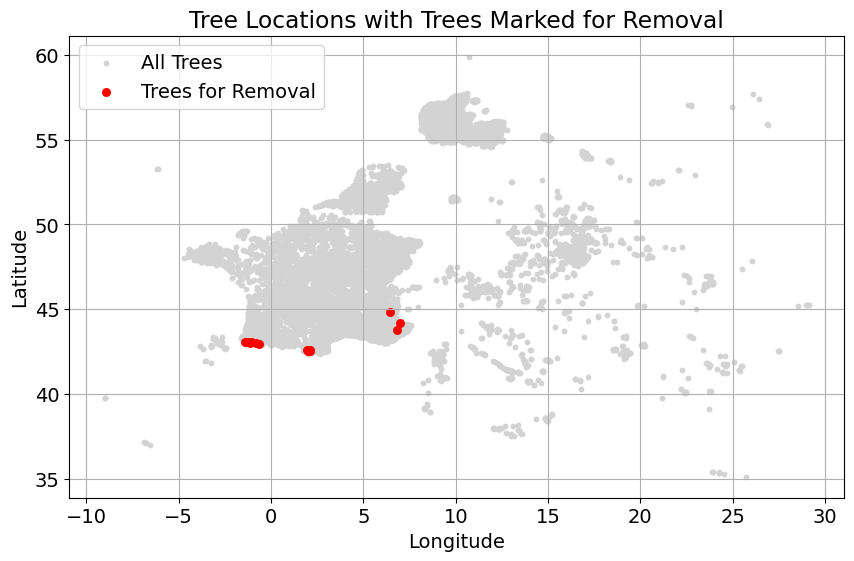

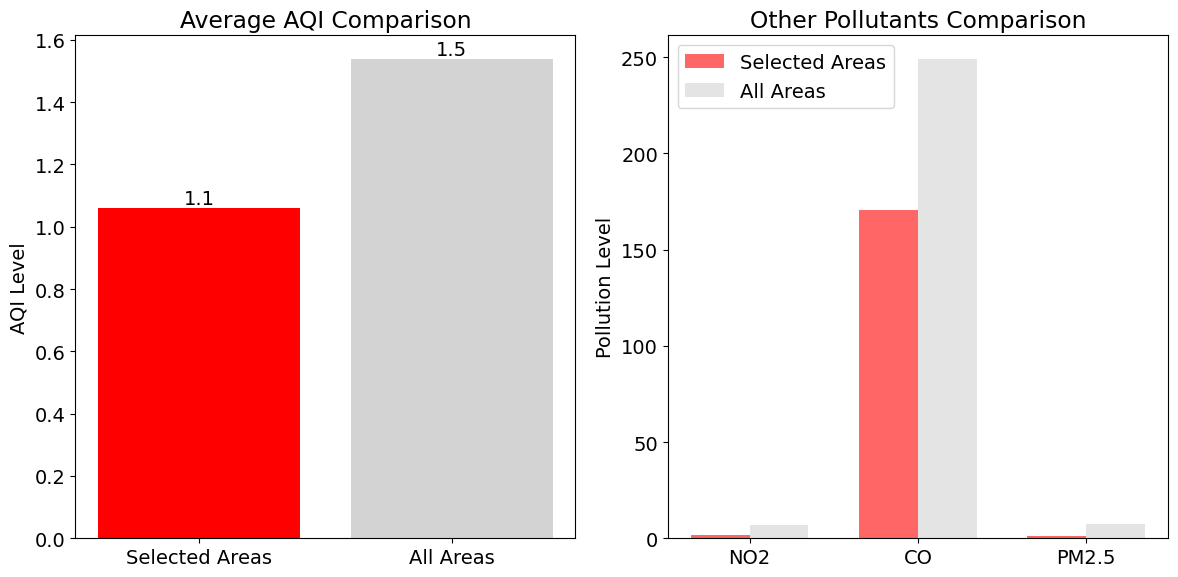


Pollution Impact Analysis:
------------------------------

AQI:
Selected Areas: 1.06
All Areas: 1.54
Difference: -31.1%

NO2:
Selected Areas: 1.72
All Areas: 6.77
Difference: -74.5%

CO:
Selected Areas: 170.53
All Areas: 248.94
Difference: -31.5%

PM2.5:
Selected Areas: 1.29
All Areas: 7.53
Difference: -82.9%


In [8]:
def evaluate_pollution_impact(selected_clusters, merged_data):
    """
    Add pollution impact evaluation to existing tree removal analysis
    """
    # Create simple visualization of pollution levels
    plt.figure(figsize=(12, 6))
    
    # Plot AQI comparison
    plt.subplot(1, 2, 1)
    selected_aqi = selected_clusters['AQI'].mean()
    overall_aqi = merged_data['AQI'].mean()
    
    bars = plt.bar(['Selected Areas', 'All Areas'], 
                  [selected_aqi, overall_aqi],
                  color=['red', 'lightgray'])
    plt.title('Average AQI Comparison')
    plt.ylabel('AQI Level')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')
    
    # Plot other pollutants
    plt.subplot(1, 2, 2)
    pollutants = ['NO2', 'CO', 'PM2.5']
    selected_means = [selected_clusters[p].mean() for p in pollutants]
    overall_means = [merged_data[p].mean() for p in pollutants]
    
    x = range(len(pollutants))
    width = 0.35
    
    plt.bar([i - width/2 for i in x], selected_means, width, 
            label='Selected Areas', color='red', alpha=0.6)
    plt.bar([i + width/2 for i in x], overall_means, width, 
            label='All Areas', color='lightgray', alpha=0.6)
    
    plt.xticks(x, pollutants)
    plt.title('Other Pollutants Comparison')
    plt.ylabel('Pollution Level')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print pollution impact statistics
    print("\nPollution Impact Analysis:")
    print("-" * 30)
    
    pollutants = ['AQI', 'NO2', 'CO', 'PM2.5']
    for pollutant in pollutants:
        selected_mean = selected_clusters[pollutant].mean()
        overall_mean = merged_data[pollutant].mean()
        diff = ((selected_mean - overall_mean) / overall_mean) * 100
        
        print(f"\n{pollutant}:")
        print(f"Selected Areas: {selected_mean:.2f}")
        print(f"All Areas: {overall_mean:.2f}")
        print(f"Difference: {diff:+.1f}%")

# Modified main_evaluation function to include pollution evaluation
def main_evaluation():
    merged_data = load_data()
    merged_data = calculate_criteria(merged_data)
    weights = calculate_weights()
    
    try:
        num_trees_to_remove = int(input("Enter the number of trees to remove: "))
    except ValueError:
        print("Invalid input. Please enter a numerical value.")
        return
        
    required_cols = ['AQI_Impact', 'Species_Importance', 'Tree_Density', 
                    'Tree_Count', 'AQI', 'NO2', 'CO', 'PM2.5']
    
    if all(col in merged_data.columns for col in required_cols):
        selected_clusters = topsis_ranking(merged_data, weights, num_trees_to_remove)
        
        print("\nRecommended Trees for Removal:")
        for idx, row in selected_clusters.iterrows():
            print(f"Species IDs: {row['speciesId']}")
            print(f"Location: ({row['average_lat']}, {row['average_lon']})\n")
        
        # Run original evaluation
        evaluate_removal_performance(selected_clusters, num_trees_to_remove, merged_data)
        
        # Add pollution evaluation
        evaluate_pollution_impact(selected_clusters, merged_data)
    else:
        print("Error: Ensure that all necessary criteria columns are present in the data.")

if __name__ == "__main__":
    main_evaluation()